# Analysis notebook

In [3]:
#Import dataframes
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
import re
import numpy as np
import wordcloud
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from wordcloud import WordCloud 
from collections import Counter
from IPython.display import display, HTML
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr
from collections import OrderedDict
import pickle
import yaml
import os

In [4]:
## Import data from csv
config = yaml.safe_load(open(f"./config/config.yaml"))

sample_size = config['datasets']['sample_size']
sample_type = "Full"
#sample_type = "Abortion"
#sample_type = "Miscarriage"
final_data_folder = config['datasets']['pickle_folder']
final_data_filename = config['datasets']['final_data_filename']
final_data_file = f"{final_data_filename}_{sample_size}.pkl"
final_data_location = os.path.join(final_data_folder, final_data_file)
df = pd.read_pickle(final_data_location)

The sample_type can be changed and reffers to a subsetting of the full dataframe to observe the differences between the discourse surrounding abortion and miscarriage individually.

In [6]:
if sample_type == "Abortion":
    df = df[df['cleaned_text'].str.contains(r'\babortion\b', case=False) & ~df['cleaned_text'].str.contains(r'\bmiscarriage\b', case=False)]
    print(len(df))
elif sample_type == "Miscarriage":
    df = df[df['cleaned_text'].str.contains(r'\bmiscarriage\b', case=False) & ~df['cleaned_text'].str.contains(r'\babortion\b', case=False)]
    print(len(df))
else:
    print(len(df))
    pass


49994


#### Data cleaning and filtering

In [12]:
print(len(df))
%run ./scripts/cleaning_steps.ipynb

df = data_cleaning(df)
print(len(df))

49994
49994
49994


/tmp/ipykernel_83187/1631023051.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 't_created_at'] = pd.to_datetime(df['t_created_at'], format='%d-%m-%y')


# Full dataset analysis

In [18]:
def addlabels(x, y, offset=0.001):
    for i in range(len(x)):
        plt.text(i, y[i] + offset, f"{y[i]:.3f}", ha='center', va='edge')
        
def addlabels_count(x, y, offset=0.001):
    for i in range(len(x)):
        plt.text(i, y[i] + offset, f"{y[i]:.0f}", ha='center', va='bottom')

### Dates and events

In [13]:
counts_by_date = df.groupby(['t_date','t_event_noyear']).size().reset_index(name='count')
counts_by_event = df.groupby('t_event').size().reset_index(name='count')
counts_by_event_noyear = df.groupby('t_event_noyear').size().reset_index(name='count')

In [14]:
# Create HTML code to display DataFrames side by side
html = """
<div style="display: flex;">
    <div style="flex: 33.33%; padding: 10px;">
    <h2>Tweet count per date and event</h2>
        {}
    </div>
    <div style="flex: 33.33%; padding: 10px;">
    <h2>Tweet count per event and year</h2>
        {}
    </div>
    <div style="flex: 33.33%; padding: 10px;">
    <h2>Tweet count per event</h2>
        {}
    </div>
</div>
""".format(counts_by_date.to_html(), counts_by_event.to_html(), counts_by_event_noyear.to_html())

# Display the HTML code
display(HTML(html))

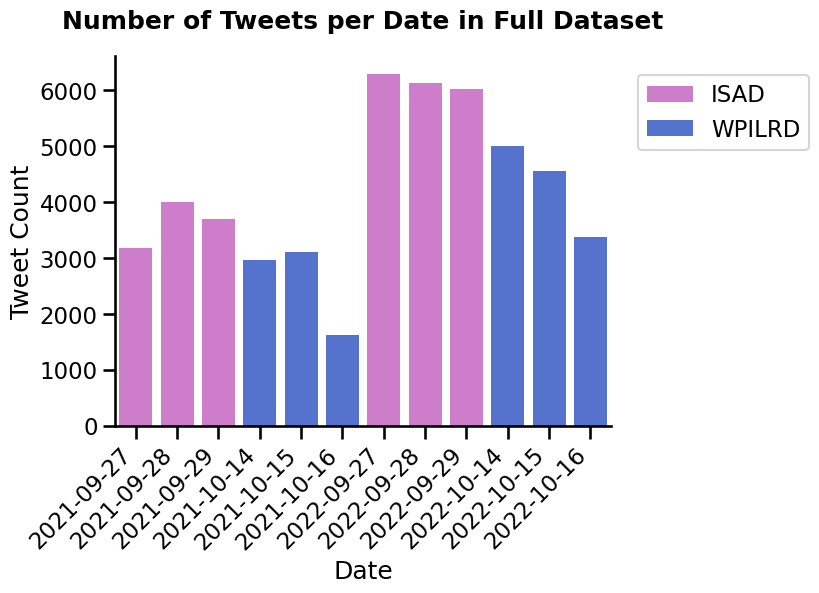

In [43]:
## See the number of tweets we have obtained per date
fig, ax = plt.subplots()

#Create a custom palette for the events with no year
event_noyear_palette = {
    'ISAD': 'orchid',
    'WPILRD': 'royalblue'
}

# If we set the context we need to remove the fontsize from the axis
sns.set_context('talk')
sns.barplot(data = counts_by_date, x = 't_date', y='count', hue='t_event_noyear', palette=event_noyear_palette, width=0.8, native_scale=True)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#Customize plot
ax.set_title('Number of Tweets per Date in {} Dataset'.format(sample_type), fontweight="bold", pad=20)
ax.set_xlabel('Date')
ax.set_ylabel('Tweet Count')

### Add the labels but they're too big and overlap. Needs fixing.
#addlabels_count(counts_by_date['t_date'], counts_by_date['count'])

plt.legend(bbox_to_anchor=(1.4, 0.95), loc='upper right', borderaxespad=0)
plt.xticks(rotation=45, ha='right')

plt.show()

#Save plot
fig.savefig(f'./data/visuals/{sample_type}_Date_count', bbox_inches='tight', pad_inches=0.1, dpi=600)
fig.savefig(f'./data/visuals/{sample_type}_Date_count.pdf', bbox_inches='tight', pad_inches=0.1, dpi=600)

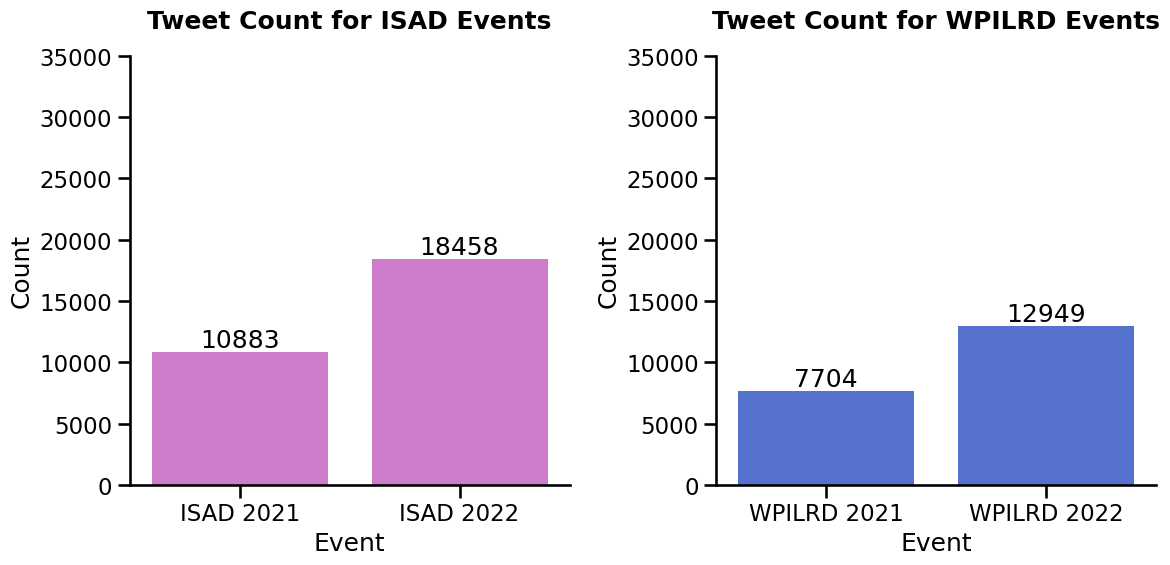

In [16]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Filter data for ISAD and WPILRD events
isad_data = counts_by_event[counts_by_event['t_event'].str.startswith('ISAD')]
wpilrd_data = counts_by_event[counts_by_event['t_event'].str.startswith('WPILRD')]

# Set y-axis limit for both plots to ensure the same length
y_max = max(isad_data['count'].max(), wpilrd_data['count'].max())
ax1.set_ylim(0, 35000)
ax2.set_ylim(0, 35000)

# Remove top and right spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Create count plots for ISAD and WPILRD
sns.barplot(data=isad_data, x='t_event', y='count', ax=ax1, color='orchid')
sns.barplot(data=wpilrd_data, x='t_event', y='count', ax=ax2, color='royalblue')

# Set titles and labels
ax1.set_title('Tweet Count for ISAD Events', fontweight="bold", pad=20)
ax1.set_xlabel('Event')
ax1.set_ylabel('Count')

ax2.set_title('Tweet Count for WPILRD Events', fontweight="bold", pad=20)
ax2.set_xlabel('Event')
ax2.set_ylabel('Count')

ax1.bar_label(ax1.containers[0], label_type='edge')
ax2.bar_label(ax2.containers[0], label_type='edge')

plt.tight_layout()

plt.show()

#Save plot
fig.savefig(f'./data/visuals/{sample_type}_Event_Year_count', bbox_inches='tight', pad_inches=0.1, dpi=600)
fig.savefig(f'./data/visuals/{sample_type}_Event_Year_count.pdf', bbox_inches='tight', pad_inches=0.1, dpi=600)

/tmp/ipykernel_83187/3884087690.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = df, x='t_event', order=order, palette=colors)


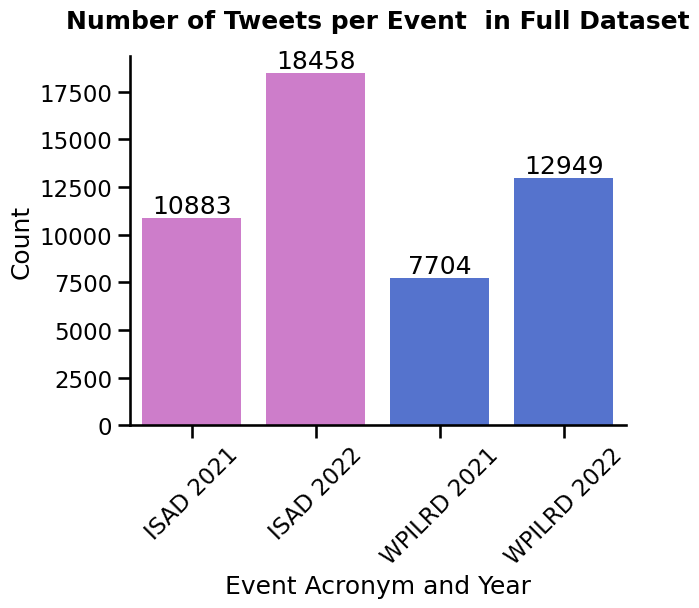

In [21]:
fig, ax = plt.subplots()
colors = {
    "ISAD 2021":"orchid", 
    "ISAD 2022":"orchid", 
    "WPILRD 2021":"royalblue", 
    "WPILRD 2022":"royalblue"
}
order = ["ISAD 2021", "ISAD 2022", "WPILRD 2021", "WPILRD 2022"]
    
sns.countplot(data = df, x='t_event', order=order, palette=colors)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Number of Tweets per Event  in {} Dataset' .format(sample_type), fontweight = "bold", pad=20)
ax.set_xlabel('Event Acronym and Year')
ax.set_ylabel('Count')
plt.xticks(rotation=45)

# Get the heights of the bars (counts) in the countplot
bar_heights = [p.get_height() for p in ax.patches]

# Use the addlabels function to add text labels to the bars
addlabels_count(order, bar_heights)
plt.show()

#Save plot
fig.savefig(f'./data/visuals/{sample_type}_event_count', bbox_inches='tight', pad_inches=0.1, dpi=600)
fig.savefig(f'./data/visuals/{sample_type}_event_count.pdf', bbox_inches='tight', pad_inches=0.1, dpi=600)

In [75]:
# Then, calculate the number of tweets per event
print('The total number of users we could predict the gender from is:',counts_by_event['count'].sum())
print('The gender proportion of each gender is: ')
print(counts_by_event['count'] / len(df))

The total number of users we could predict the gender from is: 49994
The gender proportion of each gender is: 
0    0.217686
1    0.369204
2    0.154098
3    0.259011
Name: count, dtype: float64


IndexError: list index out of range

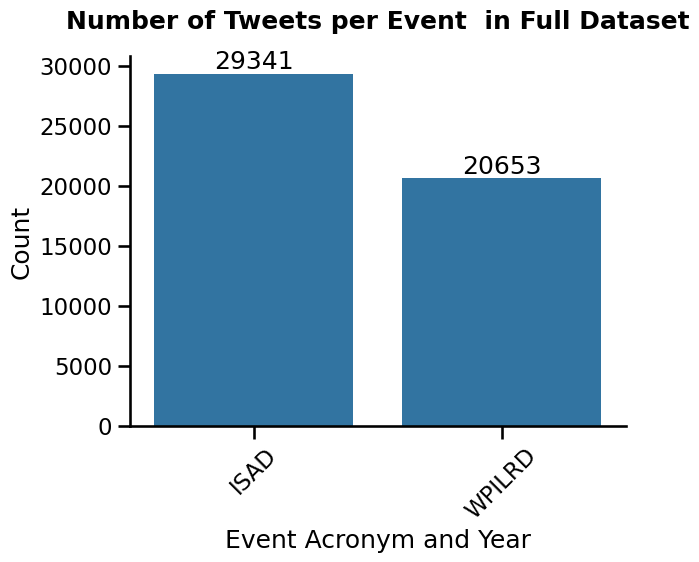

In [74]:
fig, ax = plt.subplots()

sns.countplot(data = df, x='t_event_noyear')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Number of Tweets per Event  in {} Dataset' .format(sample_type), fontweight = "bold", pad=20)
ax.set_xlabel('Event Acronym and Year')
ax.set_ylabel('Count')
plt.xticks(rotation=45)

bar_heights = [p.get_height() for p in ax.patches]

addlabels_count(x, bar_heights)
    
plt.show()


/tmp/ipykernel_83187/421310221.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='t_year', palette=year_palette)


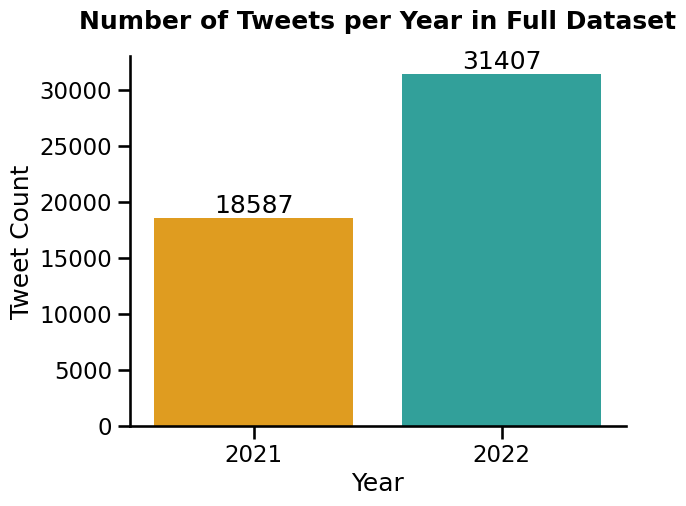

In [22]:
#Set the plot
fig, ax = plt.subplots()

#Create palette for the two studied years
year_palette = {
    '2021': 'orange',
    '2022': 'lightseagreen'
}

#Create plot
sns.countplot(data=df, x='t_year', palette=year_palette)
 
# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#Customize plot
ax.set_title('Number of Tweets per Year in {} Dataset'.format(sample_type), fontweight="bold", pad=20)
ax.set_xlabel('Year')
ax.set_ylabel('Tweet Count')

#Add labels
counts_year = df.groupby('t_year').size().reset_index(name='count')
addlabels_count(counts_year['t_year'], counts_year['count'])

#Save plot
fig.savefig(f'./data/visuals/{sample_type}_Year_count', bbox_inches='tight', pad_inches=0.1, dpi=600)
fig.savefig(f'./data/visuals/{sample_type}_Year_count.pdf', bbox_inches='tight', pad_inches=0.1, dpi=600)

### Users

In [23]:
# Drop any duplicate rows to ensure unique counts for each author
df_unique_authors = df.drop_duplicates(subset=['a_id'])

# Then, calculate the number of unique genders for each author
gender_counts = df_unique_authors['a_gender'].value_counts().reset_index(name='count')
gender_counts = pd.DataFrame(gender_counts)
display(gender_counts)
print('The total number of users we could predict the gender from is:',gender_counts['count'].sum())
print('The gender proportion of each gender is: ')
print(gender_counts['count'] / len(df_unique_authors))

index  count
0         Woman  18216
1           Man   8697
2  Unclassified   8566

The total number of users we could predict the gender from is: 35479
The gender proportion of each gender is: 
0    0.513430
1    0.245131
2    0.241439
Name: count, dtype: float64


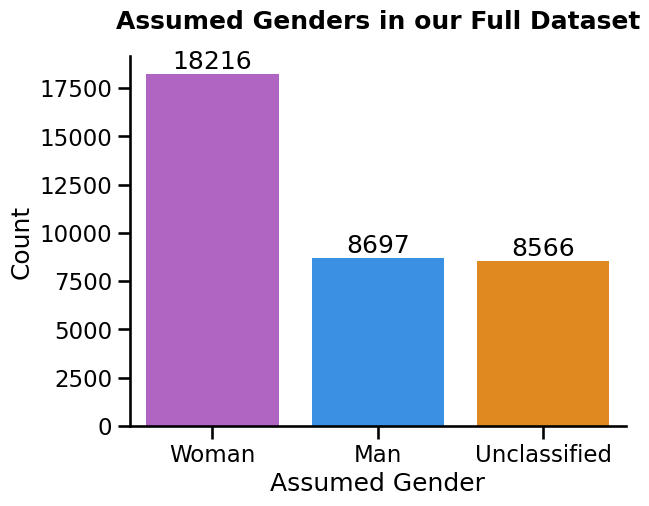

In [24]:
## See the number of tweets we have obtained per date
fig, ax = plt.subplots()

#Create a custom palette for the events with no year
gender_palette = {'Woman':'mediumorchid', 
                        'Unclassified':'darkorange', 
                        'Man':'dodgerblue'}

sns.barplot(data = gender_counts, x = 'index', y='count', hue='index', palette=gender_palette, width=0.8)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Assumed Genders in our {} Dataset'.format(sample_type), fontweight="bold", pad=20)
ax.set_xlabel('Assumed Gender')
ax.set_ylabel('Count')

# Get the heights of the bars (counts) in the countplot
bar_heights = [p.get_height() for p in ax.patches]

# Use the addlabels function to add text labels to the bars
addlabels_count(gender_counts.index, bar_heights)

plt.show() 

#Save plot
fig.savefig(f'./data/visuals/{sample_type}_gender_count.png', bbox_inches='tight', pad_inches=0.1, dpi=600)
fig.savefig(f'./data/visuals/{sample_type}_gender_count.pdf', bbox_inches='tight', pad_inches=0.1, dpi=600)

In [25]:
# Drop any duplicate rows to ensure unique counts for each author
df_unique_authors = df.drop_duplicates(subset=['a_id'])

# Then, calculate the number of unique genders for each author
verified_counts = df_unique_authors['a_verified_type'].value_counts().reset_index(name='count')
verified_counts = pd.DataFrame(verified_counts)
display(verified_counts)
print('The user proportion for the verified status are: ')
print(verified_counts['count'] / len(df_unique_authors))

index  count
0      Normal  33638
1  Blue check   1841

The user proportion for the verified status are: 
0    0.94811
1    0.05189
Name: count, dtype: float64


/tmp/ipykernel_83187/1690347003.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = df_unique_authors, x="a_verified_type", palette=verified_palette)


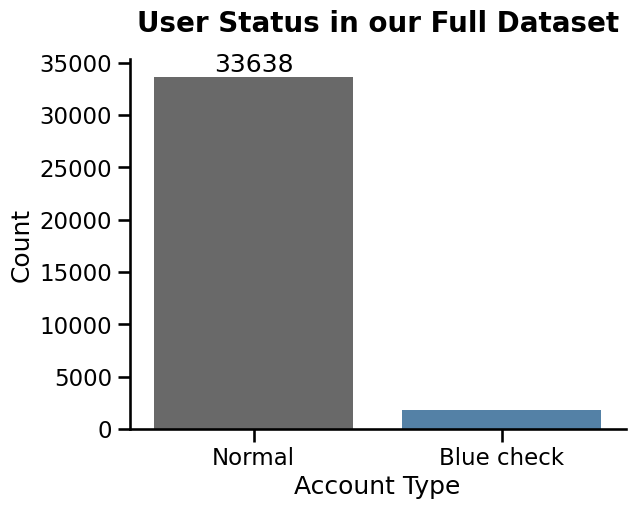

In [26]:
fig, ax = plt.subplots()

#Set color palette
verified_palette = {
    "Normal":"dimgray", 
    "Blue check":"steelblue"
}

#Plot
sns.countplot(data = df_unique_authors, x="a_verified_type", palette=verified_palette)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('User Status in our {} Dataset' .format(sample_type), fontsize=20, fontweight = "bold", pad=20)
ax.set_xlabel('Account Type')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')

plt.show()

#Save plot
fig.savefig(f'./data/visuals/{sample_type}_user_type_count', bbox_inches='tight', pad_inches=0.1, dpi=600)
fig.savefig(f'./data/visuals/{sample_type}_user_type_count.pdf', bbox_inches='tight', pad_inches=0.1, dpi=600)

In [27]:
print('The average number of tweets an author will have in our dataset is:', len(df)/len(df_unique_authors))


The average number of tweets an author will have in our dataset is: 1.4091152512754024



## Sentiment

#### General polarity and subjectivity

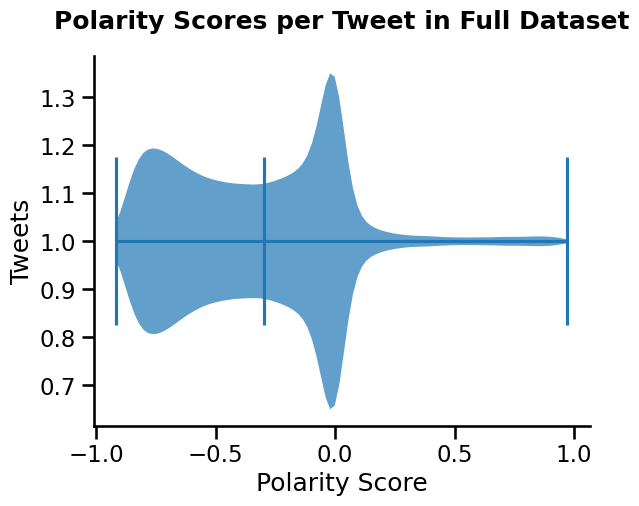

   index  t_polarity
0  count    49994.00
1   mean       -0.32
2    std        0.36
3    min       -0.92
4    25%       -0.64
5    50%       -0.30
6    75%       -0.03
7    max        0.97
8    iqr        0.61


In [28]:
fig, ax = plt.subplots()

# Create the violin plot
violin = ax.violinplot(df['t_polarity'], vert=False, widths=0.7, showmedians=True)

# Customize the plot
ax.set_xlabel('Polarity Score')
ax.set_ylabel('Tweets')
ax.set_title('Polarity Scores per Tweet in {} Dataset' .format(sample_type), fontweight='bold', pad=20)

# Add labels to the violins
for pc in violin['bodies']:
    #pc.set_facecolor('#D43F3A')  # Fill color of the violins
    pc.set_alpha(0.7)  # Transparency of the violins

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()

# Save plot
fig.savefig(f'./data/visuals/{sample_type}_polarity', bbox_inches='tight', pad_inches=0.1, dpi=600)
fig.savefig(f'./data/visuals/{sample_type}_polarity.pdf', bbox_inches='tight', pad_inches=0.1, dpi=600)

plt.show()

# Calculate summary statistics for each gender
summary_stats = df['t_polarity'].describe(percentiles=[.25, .5, .75])
summary_stats['iqr'] = summary_stats['75%'] - summary_stats['25%']
summary_stats = summary_stats.round(2)

# Print and format summary statistics as a table
formatted_table = summary_stats.reset_index()
print(formatted_table)


# Save the formatted table to a text file
formatted_table.to_csv(f'./data/visuals/{sample_type}_polarity_summary_statistics.csv', index=False)


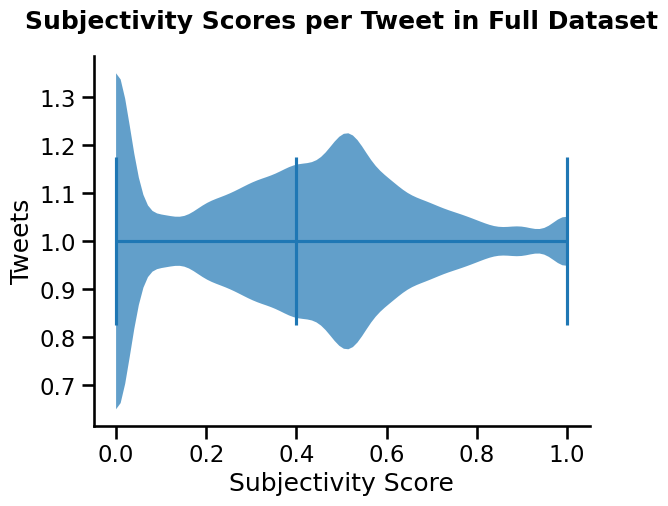

   index  t_subjectivity
0  count        49994.00
1   mean            0.38
2    std            0.28
3    min            0.00
4    25%            0.10
5    50%            0.40
6    75%            0.55
7    max            1.00
8    iqr            0.45


In [29]:
fig, ax = plt.subplots()

# Create the violin plot
violin = ax.violinplot(df['t_subjectivity'], vert=False, widths=0.7, showmedians=True)

# Customize the plot
ax.set_xlabel('Subjectivity Score')
ax.set_ylabel('Tweets')
ax.set_title('Subjectivity Scores per Tweet in {} Dataset' .format(sample_type), fontweight='bold', pad=20)

# Add labels to the violins
for pc in violin['bodies']:
    #pc.set_facecolor('#D43F3A')  # Fill color of the violins
    pc.set_alpha(0.7)  # Transparency of the violins

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()

# Save plot
fig.savefig(f'./data/visuals/{sample_type}_subjectivity', bbox_inches='tight', pad_inches=0.1, dpi=600)
fig.savefig(f'./data/visuals/{sample_type}_subjectivity.pdf', bbox_inches='tight', pad_inches=0.1, dpi=600)


# Calculate summary statistics for each gender
summary_stats = df['t_subjectivity'].describe(percentiles=[.25, .5, .75])
summary_stats['iqr'] = summary_stats['75%'] - summary_stats['25%']
summary_stats = summary_stats.round(2)

# Print and format summary statistics as a table
formatted_table = summary_stats.reset_index()
print(formatted_table)


# Save the formatted table to a text file
formatted_table.to_csv(f'./data/visuals/{sample_type}_subjectivity_summary_statistics.csv', index=False)


#### Polarity and sentiment with user inference violinplot

##### Polarity by gender and event

In [30]:
#Summary statistics

# Calculate summary statistics for each gender
summary_stats = df.groupby(['a_gender'])['t_polarity'].describe(percentiles=[.25, .5, .75])
summary_stats['iqr'] = summary_stats['75%'] - summary_stats['25%']
summary_stats = summary_stats.round(2)

# Print and format summary statistics as a table
formatted_table = summary_stats.reset_index()
print(formatted_table)

# Save the formatted table to a CSV file
#formatted_table.to_csv(f'./data/visuals/{sample_type}_polarity_gender_summary_statistics.csv', index=False)


       a_gender    count  mean   std   min   25%   50%   75%   max   iqr
0           Man  11358.0 -0.36  0.35 -0.92 -0.67 -0.36 -0.07  0.96  0.60
1  Unclassified  15053.0 -0.24  0.35 -0.91 -0.53 -0.15 -0.00  0.97  0.53
2         Woman  23583.0 -0.35  0.36 -0.92 -0.68 -0.36 -0.06  0.97  0.62


/tmp/ipykernel_83187/2091034983.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  violin = sns.violinplot(data=df, x='t_polarity', y='a_gender', palette=gender_palette, inner="quart", alpha=0.9, orient='h', width=0.7)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


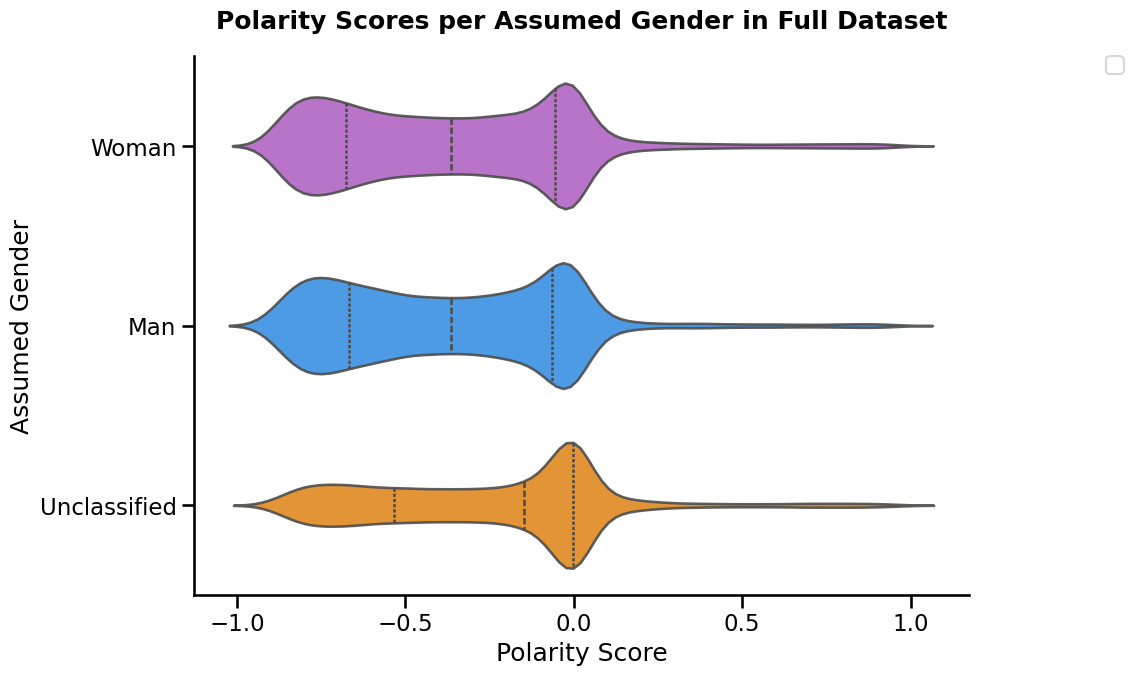

In [31]:
# Configuring the plot

fig, ax = plt.subplots(figsize=(10, 7))

violin = sns.violinplot(data=df, x='t_polarity', y='a_gender', palette=gender_palette, inner="quart", alpha=0.9, orient='h', width=0.7)

# Set labels and title
ax.set_xlabel('Polarity Score')
ax.set_ylabel('Assumed Gender')
ax.set_title('Polarity Scores per Assumed Gender in {} Dataset'.format(sample_type), fontweight="bold", pad=20)
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0)
    
# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save plot
fig.savefig(f'./data/visuals/{sample_type}_polarity_gender_violin', bbox_inches='tight', pad_inches=0.1, dpi=600)
fig.savefig(f'./data/visuals/{sample_type}_polarity_gender_violin.pdf', bbox_inches='tight', pad_inches=0.1, dpi=600)
plt.show()



In [32]:
#Summary statistics

# Calculate summary statistics for each gender
summary_stats = df.groupby(['a_gender','t_event_noyear'])['t_polarity'].describe(percentiles=[.25, .5, .75])
summary_stats['iqr'] = summary_stats['75%'] - summary_stats['25%']
summary_stats = summary_stats.round(2)

# Print and format summary statistics as a table
formatted_table = summary_stats.reset_index()
print(formatted_table)

# Save the formatted table to a CSV file
formatted_table.to_csv(f'./data/visuals/{sample_type}_polarity_gender_event_summary_statistics.csv', index=False)


       a_gender t_event_noyear    count  mean   std   min   25%   50%   75%  \
0           Man           ISAD   6496.0 -0.35  0.35 -0.92 -0.67 -0.36 -0.06   
1           Man         WPILRD   4862.0 -0.36  0.34 -0.92 -0.67 -0.37 -0.07   
2  Unclassified           ISAD   9445.0 -0.22  0.36 -0.91 -0.51 -0.12  0.00   
3  Unclassified         WPILRD   5608.0 -0.27  0.35 -0.91 -0.57 -0.19 -0.01   
4         Woman           ISAD  13400.0 -0.34  0.37 -0.92 -0.67 -0.35 -0.05   
5         Woman         WPILRD  10183.0 -0.37  0.35 -0.92 -0.68 -0.38 -0.07   

    max   iqr  
0  0.95  0.61  
1  0.96  0.60  
2  0.97  0.51  
3  0.97  0.56  
4  0.97  0.63  
5  0.96  0.61  


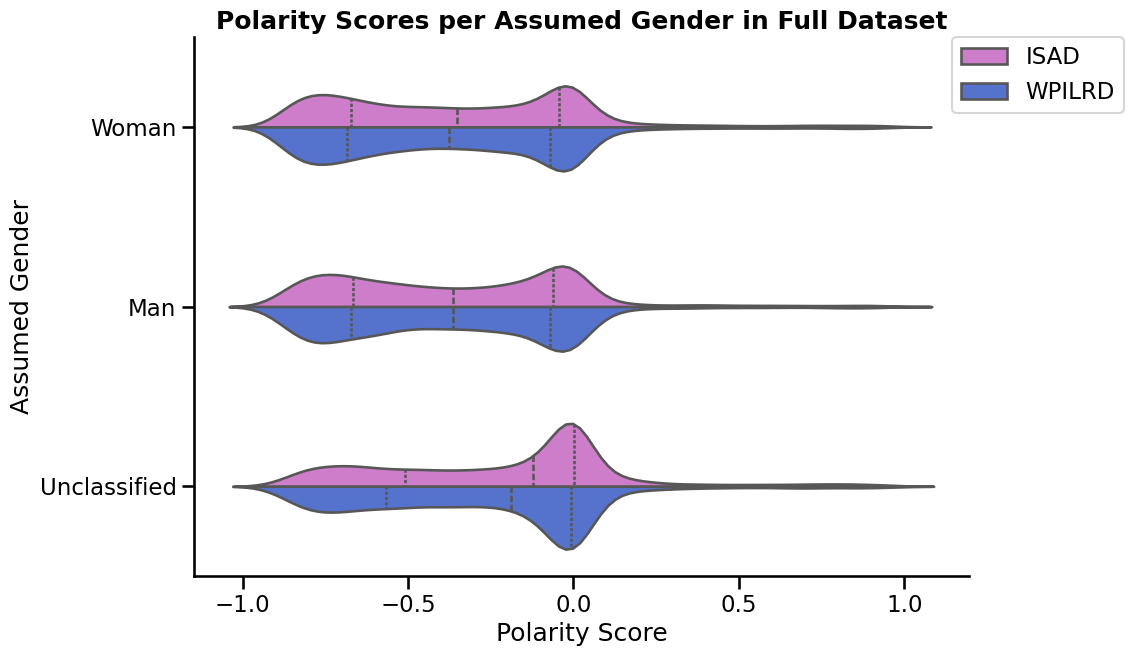

In [44]:

# Configuring the plot
fig, ax = plt.subplots(figsize=(10, 7))
sns.violinplot(data=df, x='t_polarity', y='a_gender', hue='t_event_noyear', palette=event_noyear_palette, split=True, inner="quart", orient='h', width=0.7)

# Set labels and title
ax.set_xlabel('Polarity Score')
ax.set_ylabel('Assumed Gender')
ax.set_title('Polarity Scores per Assumed Gender in {} Dataset'.format(sample_type), fontweight="bold")
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0)

# Annotate the violin plot with the mean score for each 'a_verified_type'
mean_scores = df.groupby('a_verified_type')['t_polarity'].mean() 
offset = 0.05  # Adjust this value to change the separation between annotations
for i, mean_score in enumerate(mean_scores):
    ax.annotate(f"Median: {mean_score:.3f}", xy=(i, -1.2), xytext=(0, offset),
                textcoords="offset points", ha='center')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save plot
fig.savefig(f'./data/visuals/{sample_type}_polarity_gender_event_violin', bbox_inches='tight', pad_inches=0.1, dpi=600)
fig.savefig(f'./data/visuals/{sample_type}_polarity_gender_event_violin.pdf', bbox_inches='tight', pad_inches=0.1, dpi=600)
plt.show()


##### Subjectivity by gender and event

In [37]:
#Summary statistics

# Calculate summary statistics for each gender
summary_stats = df.groupby(['a_gender'])['t_subjectivity'].describe(percentiles=[.25, .5, .75])
summary_stats['iqr'] = summary_stats['75%'] - summary_stats['25%']
summary_stats = summary_stats.round(2)

# Print and format summary statistics as a table
formatted_table = summary_stats.reset_index()
print(formatted_table)

# Save the formatted table to a CSV file
formatted_table.to_csv(f'./data/visuals/{sample_type}_subjectivity_gender_summary_statistics.csv', index=False)


       a_gender    count  mean   std  min  25%   50%   75%  max   iqr
0           Man  11358.0  0.38  0.28  0.0  0.1  0.40  0.56  1.0  0.46
1  Unclassified  15053.0  0.36  0.27  0.0  0.1  0.39  0.54  1.0  0.44
2         Woman  23583.0  0.38  0.29  0.0  0.1  0.41  0.57  1.0  0.47


/tmp/ipykernel_83187/423537156.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='t_subjectivity', y='a_gender', palette=gender_palette, inner="quart", orient='h', width=0.7)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


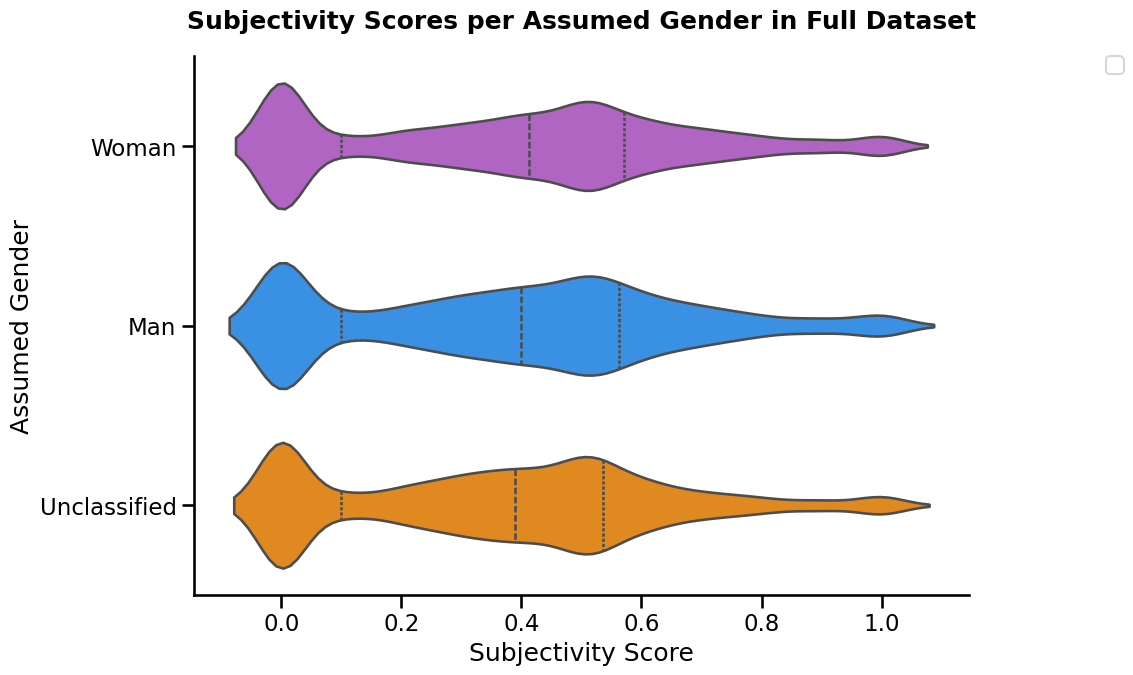

In [38]:
# Configuring the plot

fig, ax = plt.subplots(figsize=(10, 7))
sns.violinplot(data=df, x='t_subjectivity', y='a_gender', palette=gender_palette, inner="quart", orient='h', width=0.7)

# Set labels and title
ax.set_xlabel('Subjectivity Score')
ax.set_ylabel('Assumed Gender')
ax.set_title('Subjectivity Scores per Assumed Gender in {} Dataset'.format(sample_type), fontweight="bold", pad=20)
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

#Save plot
fig.savefig(f'./data/visuals/{sample_type}_subjectivity_gender_violin', bbox_inches='tight', pad_inches=0.1, dpi=600)
fig.savefig(f'./data/visuals/{sample_type}_subjectivity_gender_violin.pdf', bbox_inches='tight', pad_inches=0.1, dpi=600)


In [39]:
#Summary statistics

# Calculate summary statistics for each gender
summary_stats = df.groupby(['a_gender','t_event_noyear'])['t_subjectivity'].describe(percentiles=[.25, .5, .75])
summary_stats['iqr'] = summary_stats['75%'] - summary_stats['25%']
summary_stats = summary_stats.round(2)

# Print and format summary statistics as a table
formatted_table = summary_stats.reset_index()
print(formatted_table)

# Save the formatted table to a CSV file
formatted_table.to_csv(f'./data/visuals/{sample_type}_subjectivity_gender_event_summary_statistics.csv', index=False)

       a_gender t_event_noyear    count  mean   std  min   25%   50%   75%  \
0           Man           ISAD   6496.0  0.38  0.28  0.0  0.10  0.40  0.56   
1           Man         WPILRD   4862.0  0.38  0.28  0.0  0.10  0.40  0.57   
2  Unclassified           ISAD   9445.0  0.37  0.26  0.0  0.12  0.39  0.54   
3  Unclassified         WPILRD   5608.0  0.36  0.28  0.0  0.08  0.38  0.54   
4         Woman           ISAD  13400.0  0.39  0.28  0.0  0.10  0.42  0.57   
5         Woman         WPILRD  10183.0  0.38  0.29  0.0  0.05  0.40  0.57   

   max   iqr  
0  1.0  0.46  
1  1.0  0.47  
2  1.0  0.42  
3  1.0  0.46  
4  1.0  0.47  
5  1.0  0.52  


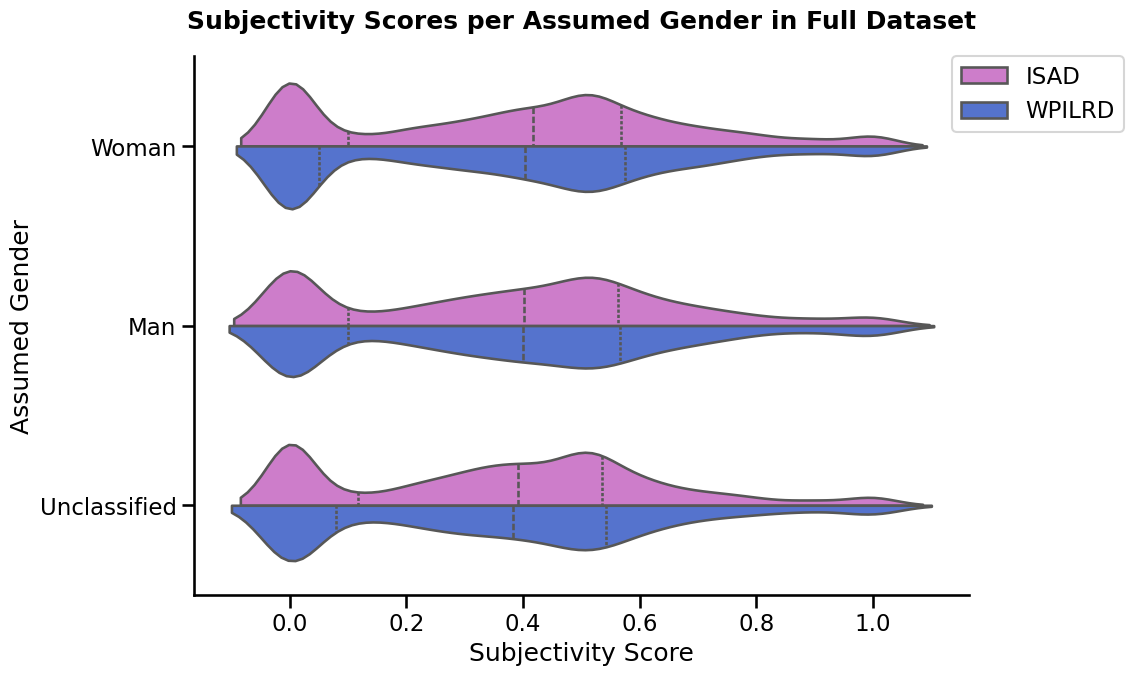

In [46]:
# Configuring the plot

fig, ax = plt.subplots(figsize=(10, 7))
sns.violinplot(data=df, x='t_subjectivity', y='a_gender', hue='t_event_noyear', palette=event_noyear_palette, split=True, inner="quart", orient='h', width=0.7)

# Set labels and title
ax.set_xlabel('Subjectivity Score')
ax.set_ylabel('Assumed Gender')
ax.set_title('Subjectivity Scores per Assumed Gender in {} Dataset'.format(sample_type), fontweight="bold", pad=20)
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0)


# Annotate the violin plot with the mean score for each 'a_verified_type'
mean = df.groupby('a_verified_type')['t_subjectivity'].mean()
offset = 0.05  # Adjust this value to change the separation between annotations
for i, mean in enumerate(mean):
    ax.annotate(f"Median: {mean:.2f}", xy=(i, -1.2), xytext=(0, offset),
                textcoords="offset points", ha='center')
    
# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

#Save plot
fig.savefig(f'./data/visuals/{sample_type}_subjectivity_gender_event_violin', bbox_inches='tight', pad_inches=0.1, dpi=600)
fig.savefig(f'./data/visuals/{sample_type}_subjectivity_gender_event_violin.pdf', bbox_inches='tight', pad_inches=0.1, dpi=600)


#### Subjectivity and polarity per event

##### Polarity by event and year

In [47]:
#Summary statistics
summary_stats = df.groupby(['t_event_noyear', 't_year'])['t_polarity'].describe(percentiles=[.25, .5, .75])
summary_stats['iqr'] = summary_stats['75%'] - summary_stats['25%']
summary_stats = summary_stats.round(2)

# Print and format summary statistics as a table
formatted_table = summary_stats.reset_index()
print(formatted_table)

# Save the formatted table to a text file
formatted_table.to_csv(f'./data/visuals/{sample_type}_polarity_event_year_summary_statistics.csv', index=False)


  t_event_noyear  t_year    count  mean   std   min   25%   50%   75%   max  \
0           ISAD    2021  10883.0 -0.28  0.37 -0.92 -0.61 -0.24 -0.01  0.97   
1           ISAD    2022  18458.0 -0.32  0.36 -0.92 -0.64 -0.30 -0.03  0.97   
2         WPILRD    2021   7704.0 -0.33  0.36 -0.92 -0.65 -0.30 -0.03  0.97   
3         WPILRD    2022  12949.0 -0.35  0.35 -0.92 -0.66 -0.34 -0.05  0.96   

    iqr  
0  0.60  
1  0.61  
2  0.62  
3  0.61  


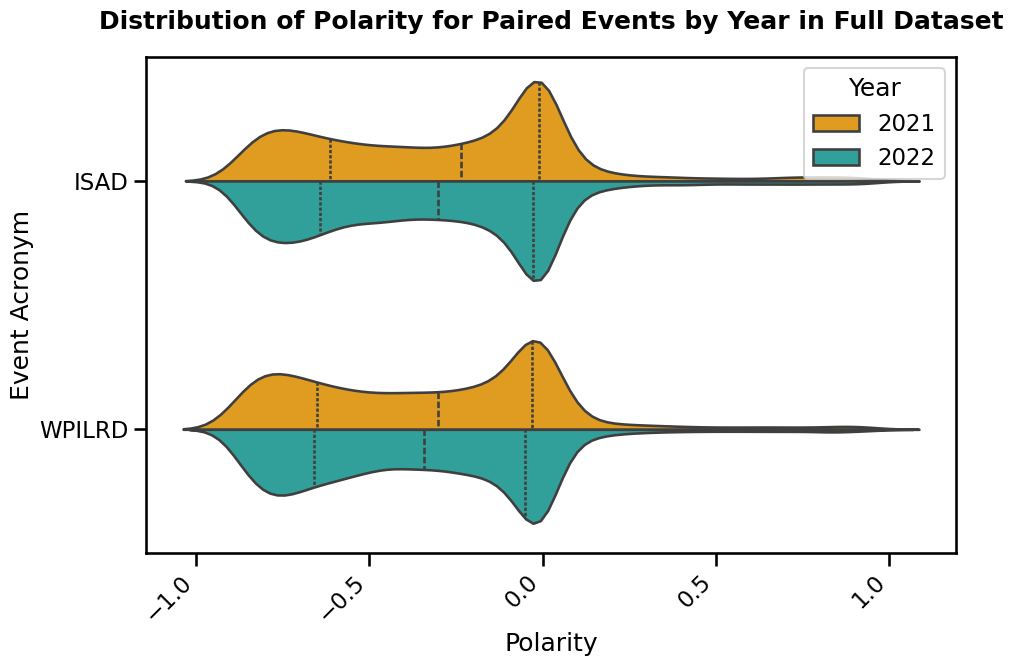

In [48]:
fig, ax = plt.subplots(figsize=(10, 7)) 

color_list = ['orange','lightseagreen']
sns.violinplot(data=df, x="t_polarity", y="t_event_noyear", hue="t_year", palette=color_list, split=True, inner="quart")

# Customize labels and title
plt.xlabel("Polarity")
plt.ylabel("Event Acronym")
plt.title("Distribution of Polarity for Paired Events by Year in {} Dataset" .format(sample_type), fontweight = "bold", pad=20)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Show the legend
plt.legend(title="Year")

# Show the plot
plt.tight_layout()
plt.show()

#Save plot
fig.savefig(f'./data/visuals/{sample_type}_polarity_event_year_violin', bbox_inches='tight', pad_inches=0.1, dpi=600)
fig.savefig(f'./data/visuals/{sample_type}_polarity_event_year_violin.pdf', bbox_inches='tight', pad_inches=0.1, dpi=600)



##### Subjectivity by event and year

In [49]:
#Summary statistics

summary_stats = df.groupby(['t_event_noyear', 't_year'])['t_subjectivity'].describe(percentiles=[.25, .5, .75])
summary_stats['iqr'] = summary_stats['75%'] - summary_stats['25%']
summary_stats = summary_stats.round(2)


# Print and format summary statistics as a table
formatted_table = summary_stats.reset_index()
print(formatted_table)

# Save the formatted table to a text file
formatted_table.to_csv(f'./data/visuals/{sample_type}_subjectivity_event_year_summary_statistics.csv', index=False)


  t_event_noyear  t_year    count  mean   std  min   25%  50%   75%  max   iqr
0           ISAD    2021  10883.0  0.38  0.28  0.0  0.10  0.4  0.55  1.0  0.45
1           ISAD    2022  18458.0  0.38  0.27  0.0  0.12  0.4  0.55  1.0  0.43
2         WPILRD    2021   7704.0  0.36  0.29  0.0  0.00  0.4  0.56  1.0  0.56
3         WPILRD    2022  12949.0  0.38  0.29  0.0  0.10  0.4  0.57  1.0  0.47


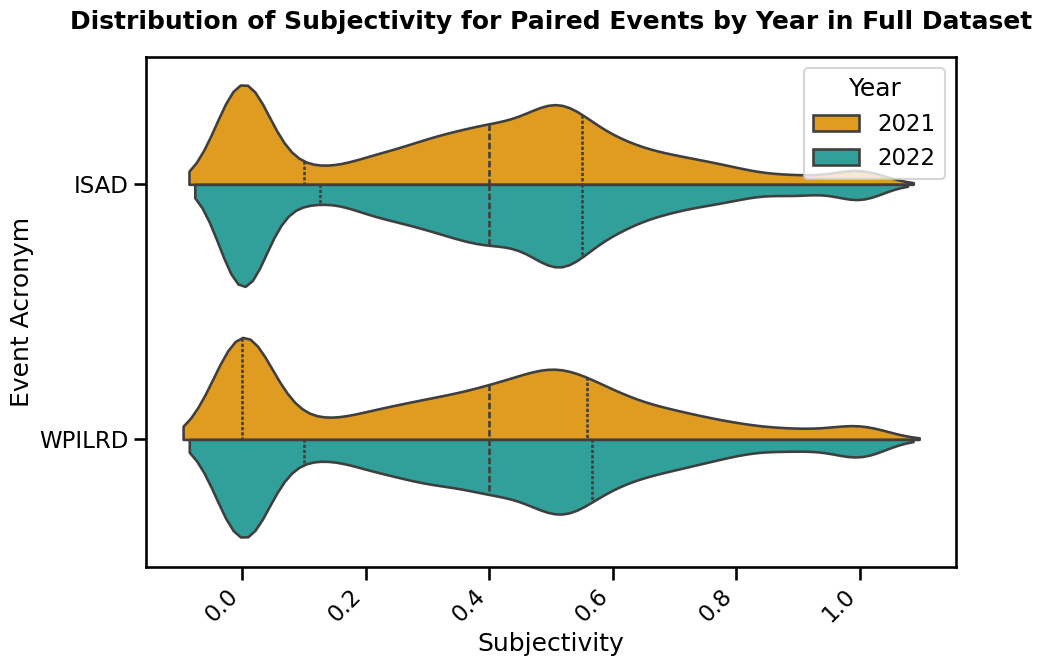

In [50]:
fig, ax = plt.subplots(figsize=(10, 7)) 
sns.violinplot(data=df, x="t_subjectivity", y="t_event_noyear", hue="t_year", palette=color_list, split=True, inner="quart")

# Customize labels and title
plt.xlabel("Subjectivity")
plt.ylabel("Event Acronym")
plt.title("Distribution of Subjectivity for Paired Events by Year in {} Dataset" .format(sample_type), fontweight = "bold", pad=20)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Show the legend
plt.legend(title="Year")

# Show the plot
plt.tight_layout()
plt.show()

#Save plot
fig.savefig(f'./data/visuals/{sample_type}_subjectivity_event_year_violin', bbox_inches='tight', pad_inches=0.1, dpi=600)
fig.savefig(f'./data/visuals/{sample_type}_subjectivity_event_year_violin.pdf', bbox_inches='tight', pad_inches=0.1, dpi=600)



## Social Metrics

In [51]:
#Create plots for the different social media distributions:

In [52]:
#df.columns
#'t_retweet_count','t_reply_count', 't_like_count', 't_quote_count'

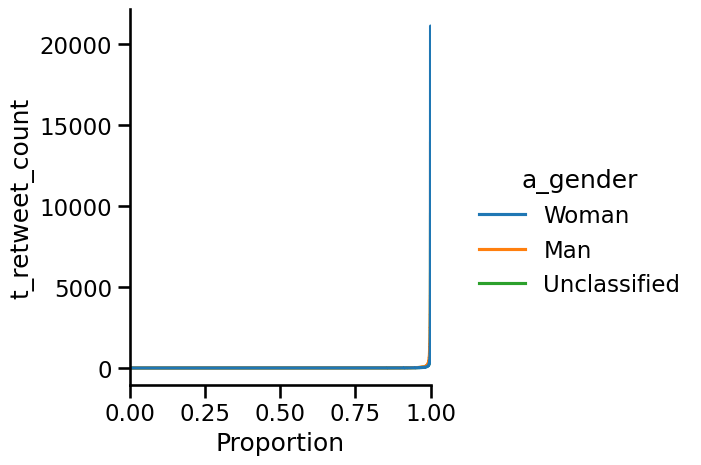

In [53]:
# Create separate KDE plots for each category
g = sns.displot(df, y="t_retweet_count", hue="a_gender", kind='ecdf')

# Show the plots
plt.show()

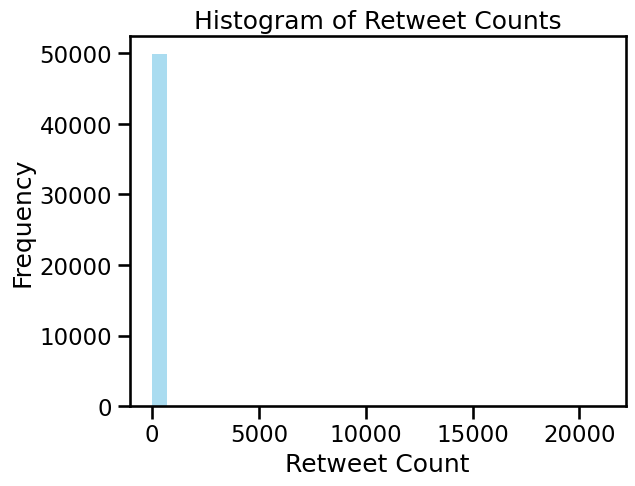

In [54]:
plt.hist(df['t_retweet_count'], bins=30, color='skyblue', alpha=0.7)
plt.xlabel('Retweet Count')
plt.ylabel('Frequency')
plt.title('Histogram of Retweet Counts')
plt.show()

/tmp/ipykernel_83187/2403238728.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df, x='t_retweet_count', shade=True)


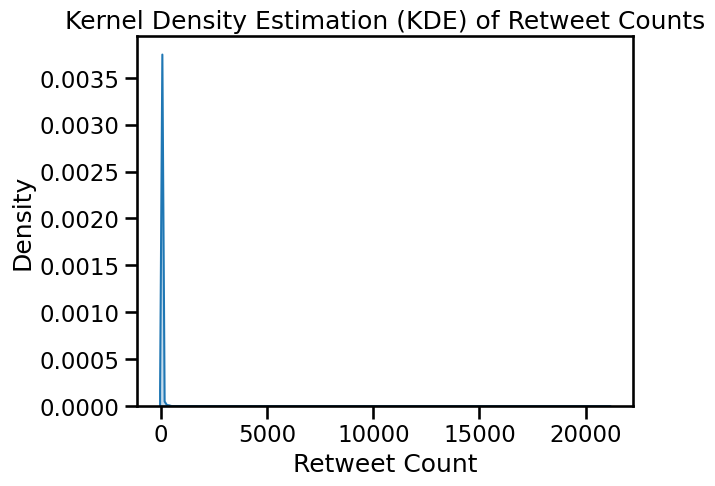

In [55]:
sns.kdeplot(data=df, x='t_retweet_count', shade=True)
plt.xlabel('Retweet Count')
plt.ylabel('Density')
plt.title('Kernel Density Estimation (KDE) of Retweet Counts')
plt.show()

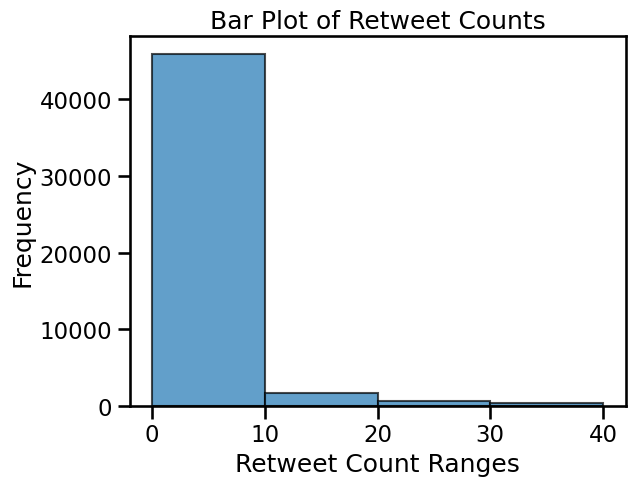

In [56]:
bin_edges = [0, 10, 20, 30, 40]  # Define your own bins
plt.hist(df['t_retweet_count'], bins=bin_edges, edgecolor='black', alpha=0.7)
plt.xlabel('Retweet Count Ranges')
plt.ylabel('Frequency')
plt.title('Bar Plot of Retweet Counts')
plt.show()

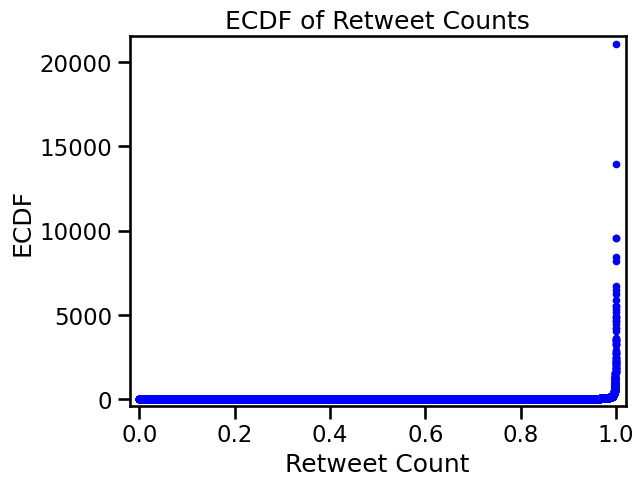

In [57]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    return x, y

y, x = ecdf(df['t_retweet_count'])
plt.plot(x, y, marker='.', linestyle='none', color='b')
plt.xlabel('Retweet Count')
plt.ylabel('ECDF')
plt.title('ECDF of Retweet Counts')
plt.margins(0.02)  # Add a little margin
plt.show()

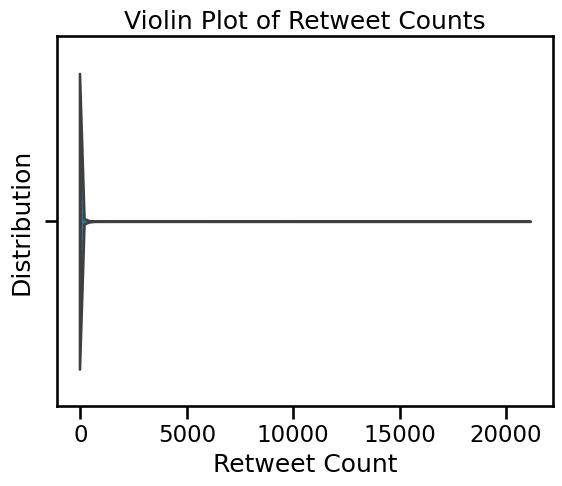

In [58]:
sns.violinplot(data=df, x='t_retweet_count', inner="quart")
plt.xlabel('Retweet Count')
plt.ylabel('Distribution')
plt.title('Violin Plot of Retweet Counts')
plt.show()

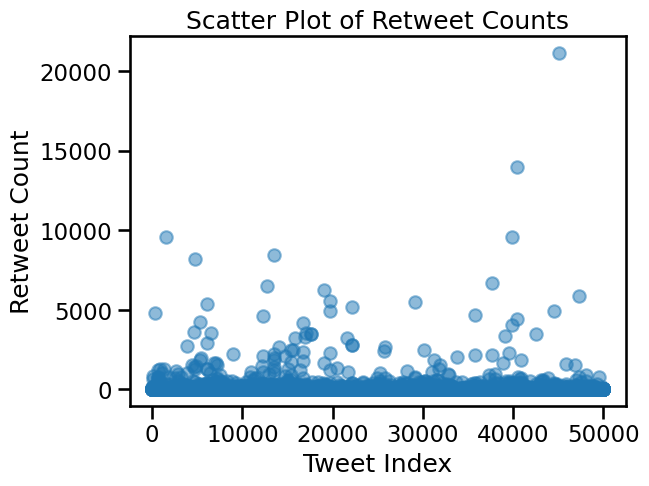

In [59]:
plt.scatter(df.index, df['t_retweet_count'], alpha=0.5)
plt.xlabel('Tweet Index')
plt.ylabel('Retweet Count')
plt.title('Scatter Plot of Retweet Counts')
plt.show()

In [60]:
noise = len(df[df['t_topic'] == -1])
total = len(df)
noise_percentage = round(noise / total, 4)
print("Number of documents that are noise (t_topic -1): " + str(noise))
print("Total number of documents: " + str(total))
print("Percentage of documents that are noise: " + str(noise_percentage))

Number of documents that are noise (t_topic -1): 16218
Total number of documents: 49994
Percentage of documents that are noise: 0.3244


In [61]:
# topic_info = topic_model.get_topic_info()
# display(topic_info)

In [62]:
# Created df that has counts of tweets per topic
grouped = df.groupby(['t_topic']).size().reset_index(name='Count').sort_values(by='Count', ascending=False).drop(0, axis=0)

grouped_sorted = grouped.sort_values('Count', ascending=False)
string_array = list(map(str, grouped_sorted['t_topic']))


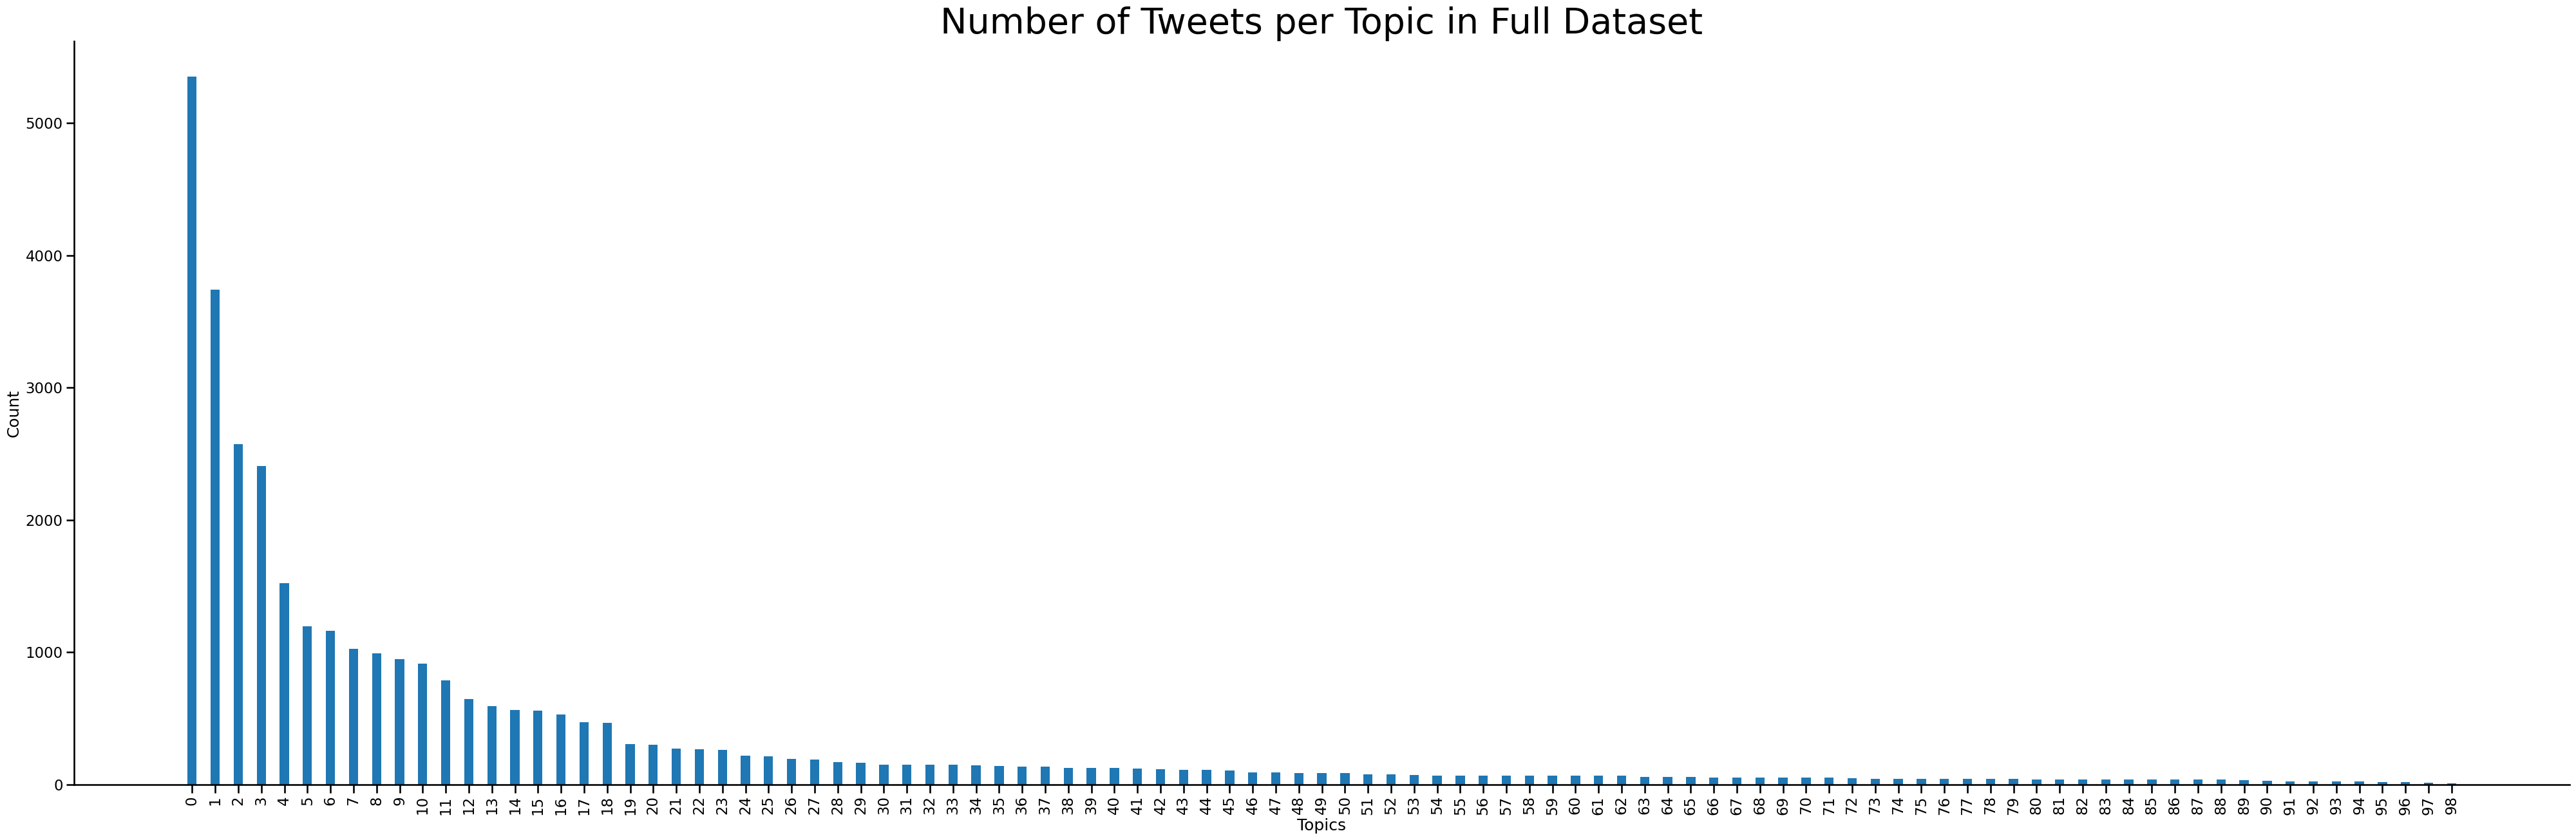

In [63]:
#### Tweets per topic
fig, ax = plt.subplots(figsize=(50, 15))

plt.bar(string_array, grouped_sorted['Count'], width=0.4)
plt.xlabel('Topics')
plt.ylabel('Count')
plt.title('Number of Tweets per Topic in {} Dataset' .format(sample_type), fontsize=40)
plt.xticks(rotation=90)  # Rotate the x-axis labels for better visibility

# Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

#Save plot
fig.savefig(f'./data/visuals/{sample_type}_topic_count', bbox_inches='tight', pad_inches=0.1, dpi=600)
fig.savefig(f'./data/visuals/{sample_type}_topic_count.pdf', bbox_inches='tight', pad_inches=0.1, dpi=600)

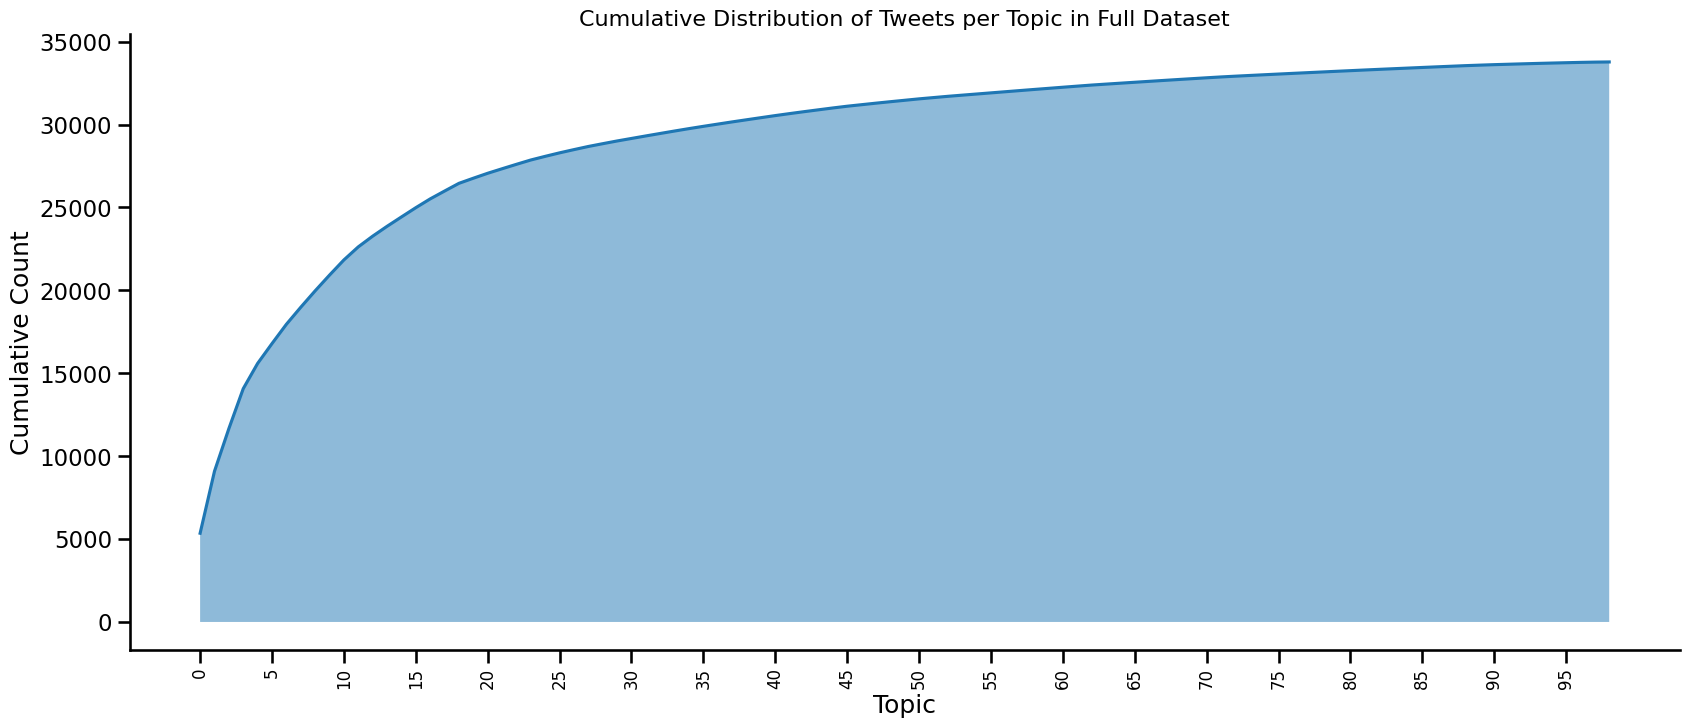

In [64]:
#### Calculate the cumulative sum of counts

cumulative_counts = np.cumsum(grouped_sorted['Count'])

# Create a range for the x-axis
x = np.arange(len(grouped_sorted))

fig, ax = plt.subplots(figsize=(20,8))

# Create the CDF plot
plt.plot(x, cumulative_counts)

plt.fill_between(x, cumulative_counts, alpha=0.5)


# Set the tick labels as the topics
plt.xticks(x, grouped_sorted['t_topic'], rotation=90)

# Set the axis labels
plt.xlabel('Topic')
plt.xticks(range(0, len(df['t_topic'].unique()), 5), fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Cumulative Count')
plt.title('Cumulative Distribution of Tweets per Topic in {} Dataset' .format(sample_type),fontsize=16)

# Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

#Save plot
fig.savefig(f'./data/visuals/{sample_type}_topic_distribution', bbox_inches='tight', pad_inches=0.1, dpi=600)
fig.savefig(f'./data/visuals/{sample_type}_topic_distribution.pdf', bbox_inches='tight', pad_inches=0.1, dpi=600)

In [ ]:
# #### Topic Words Scores Barchart
# topic_model.visualize_barchart() 

In [ ]:
# #### Topic Labels List
# topic_model.generate_topic_labels(nr_words=10) 

In [ ]:
# ##### Hierarchical Clustering Graph
# hierarchical_topics = topic_model.hierarchical_topics(docs)
# topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

#### Generate Top N Topics Data

In [ ]:
# Specificy the subset of topics you want to generate visuals for
n = 10

 # Get list of top n topic labels
top_n_topics = grouped.head(n)
#top_n_topics = top_n_topics.drop(top_n_topics.index[0])
top_n_topics_list = top_n_topics['t_topic'].tolist()
df_topics_top_n = df[df['t_topic'].isin(top_n_topics_list)]

print(top_n_topics_list)

In [ ]:
# # Gather subset of embeddings and reduced embeddings that pertain to the documents of the top n topics
# docs_top_n = []
# embeddings_top_n = []
# reduced_embeddings_top_n = []
# topics_key_top_n = []
# for index, row in df_topics_top_n.iterrows():
#     for i in range (0, len(docs),1):
#         if (docs[i] == row['cleaned_text']):
#             docs_top_n.append(docs[i])
#             embeddings_top_n.append(embeddings[i])
#             reduced_embeddings_top_n.append(reduced_embeddings[i])
#             topics_key_top_n.append(row['t_topic'])
#             break
# # Note: the above cell takes about 19 minutes to execute when n=10

In [ ]:
#### Scatter Plot of Cluster

# Multidimensional scatter plot showing distribution of tweets by topic, reduces dimensions of embeddings down to 2

# embeddings_top_n = np.array(embeddings_top_n)

# This gives us a 1D array of the top topic number associated with each document
# topic_num = df_topics_top_n['t_topic']

# # Turn multidimensional document vs topics vs probability model into 2-dimensional model
# tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
# tsne_lda = tsne_model.fit_transform(embeddings_top_n)

# # Visualize this model
# output_notebook()

# #mycolors = np.array([color for name, color in mcolors.CSS4_COLORS.items()])
# #note that there are only 21 colors so at most n can be 21 for this graph to work (we can figure out a way to change this)
# mycolors = np.array([mcolors.CSS4_COLORS['crimson'], mcolors.CSS4_COLORS['hotpink'],mcolors.CSS4_COLORS['darkorchid'], 
#             mcolors.CSS4_COLORS['blue'], mcolors.CSS4_COLORS['deepskyblue'], mcolors.CSS4_COLORS['turquoise'],
#             mcolors.CSS4_COLORS['mediumseagreen'], mcolors.CSS4_COLORS['forestgreen'], mcolors.CSS4_COLORS['lawngreen'],
#             mcolors.CSS4_COLORS['yellow'], mcolors.CSS4_COLORS['goldenrod'], mcolors.CSS4_COLORS['chocolate'],
#             mcolors.CSS4_COLORS['orangered'], mcolors.CSS4_COLORS['firebrick'], mcolors.CSS4_COLORS['slategray'],
#             mcolors.CSS4_COLORS['black'], mcolors.CSS4_COLORS['saddlebrown'], mcolors.CSS4_COLORS['lightpink'],
#             mcolors.CSS4_COLORS['cyan'], mcolors.CSS4_COLORS['olive'], mcolors.CSS4_COLORS['darkkhaki']])

# topic_colors = {}
# topics = topic_num.unique()

# for i in range(0,len(topics),1):
#     temp = {topics[i]: mycolors[i]}
#     topic_colors.update(temp)

# # Create a list of topic labels for the legend
# legend_labels = [Div(text='<span style="display: flex; align-items: center;"><span style="background-color:{}; width: 10px; height: 10px; margin-right: 5px;"></span>Topic {}</span>'.format(topic_colors[topic], topic),
#                      width=120, height=30) for topic in topic_num.unique()]

# n_topics = len(df_topics_top_n['t_topic'].unique())
# plot = figure(title="Clustering of Top N Topics".format(n_topics), min_width=900, min_height=700)
# plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=[topic_colors[topic] for topic in topic_num])

# legend = column(legend_labels)
# layout = gridplot([[plot, legend]])
# show(layout)


#Save plot
# fig.savefig(f'./data/visuals/{sample_type}_ntopics_cluster_scatter', bbox_inches='tight', pad_inches=0.1, dpi=600)

In [ ]:
#### WordClouds of Topics

num_topics = len(top_n_topics_list)
num_rows = int(np.ceil(np.sqrt(num_topics)))  # Number of rows in the plot
num_cols = int(np.ceil(num_topics / num_rows))  # Number of columns in the plot

# # Create a figure and subplots
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))

# def create_wordcloud(model, topic, row, col):
#     text = {word: value for word, value in model.get_topic(topic)}
#     wc = WordCloud(background_color="white", max_words=10)
#     wc.generate_from_frequencies(text)
#     axes[row,col].imshow(wc)
#     #axes[row,col].set_title(f"Topic {top_n_topics_list[i]}")
#     axes[row,col].axis('off')

# row = -1
# col = 0
# for i in range(0,num_rows*num_cols,1):
#     col = i%num_cols
#     if (i >= num_topics):
#         axes[row,col].set_visible(False)
#     else:
#         if(col == 0):
#             row += 1
#         create_wordcloud(topic_model, topic=i, row=row, col=col)

#plt.subplots_adjust(wspace=0.8, hspace=0.5)
# plt.show()

#Save plot
# fig.savefig(f'./data/visuals/{sample_type}_ntopics_wordcloud', bbox_inches='tight', pad_inches=0.1, dpi=600)

In [ ]:
total_topics = df['t_topic'].nunique()
total_topics

In [ ]:
df_topics_top_n = df[df['t_topic'].isin(top_n_topics_list)]
grouped_top_n = df_topics_top_n.groupby(['t_topic']).size().reset_index(name='Count').sort_values(by='Count', ascending=False)

In [ ]:
# Percentages of tweets labeled each topic (top n) table (excluding noise)
grouped_top_n_percentages = round(grouped_top_n['Count']/(len(df)-noise)*100,2)
print("Percentages of tweets labeled each topic in {} Dataset (top n):".format(sample_type))
display(grouped_top_n_percentages)

In [ ]:
## Display the labels and topic number:
topic_labels = df_topics_top_n[['t_topic', 't_topic_label']].drop_duplicates().sort_values(by='t_topic').reset_index()
topic_labels.to_csv(f'./data/visuals/{sample_type}_topics_labels.csv', index=False)
topic_labels

#### Radar plot topic

In [ ]:
# Calculate scaled polarity values
df_topics_top_n['scaled_polarity'] = (df_topics_top_n['t_polarity'] + 1) / 2
df_topics_top_n['original_polarity'] = (df_topics_top_n['scaled_polarity'] * 2) - 1

# Group the data by 't_topic'
grouped_radar = df_topics_top_n.groupby('t_topic').agg(
    avg_subjectivity=('t_subjectivity', 'median'),
    avg_scaled_polarity=('scaled_polarity', 'median'),
    original_polarity=('t_polarity', 'median'),
    topic_count=('t_depression', 'count'),
    proportion_women=('a_gender', lambda x: (x == 'Woman').mean()),
    proportion_men=('a_gender', lambda x: (x == 'Man').mean()),
    combined_depression_count=('t_depression', 
                               lambda x: ((x == 'moderate depression') | (x == 'severe depression')).sum())
).reset_index()

# Calculate proportion of combined depression
grouped_radar['combined_depression'] = (grouped_radar['combined_depression_count'] / grouped_radar['topic_count'])
# Drop unnecessary columns
# grouped_radar.drop(columns=['percentage_combined_depression'], inplace=True)

grouped_radar


In [ ]:
# Print and format summary statistics as a table
formatted_table = grouped_radar.reset_index()

# Save the formatted table to a CSV file
formatted_table.to_csv(f'./data/visuals/{sample_type}_topics_summary_statistics.csv', index=False)

In [ ]:
# Create individual dictionaries for each row
individual_dicts = []
for index, row in grouped_radar.iterrows():
    row_dict = {
        'Subjectivity': row['avg_subjectivity'],
        'Polarity': row['avg_scaled_polarity'],
        'Men': row['proportion_men'],
        'Women': row['proportion_women']
    }
    individual_dicts.append(row_dict)

# Print the individual dictionaries
for row_dict in individual_dicts:
    print(row_dict)

In [ ]:
# Create subplots
fig = make_subplots(rows=5, cols=2, specs=[[{'type': 'polar'}]*2]*5)

# Iterate through individual dictionaries and create radar charts
for index, row_dict in enumerate(individual_dicts):
    row = index // 2 + 1
    col = index % 2 + 1
    
    radar_chart = go.Scatterpolar(
        r=list(row_dict.values()),
        theta=list(row_dict.keys()),
        fill='toself',
        name=f'Chart {index + 1}'
    )
    
    fig.add_trace(radar_chart, row=row, col=col)

fig.update_traces(fill='toself')

# Update layout for polar plots
fig.update_layout(
    polar=dict(
        radialaxis=dict(visible=True, range=[0, 1]),
        angularaxis=dict(showline=True, showgrid=True, tickvals=[0, 45, 90, 135, 180, 225, 270, 315]),
    ),
    title='Radar Charts for Each Dictionary',
    width=1300,  # Adjust width to make plots wider
    height=2000  # Adjust height to make plots taller
)


# Show the charts
fig.show()

#Save plot
plt.savefig(f'./data/visuals/{sample_type}_topics_radar', bbox_inches='tight', pad_inches=0.1, dpi=600)
plt.savefig(f'./data/visuals/{sample_type}_topics_radar.pdf', bbox_inches='tight', pad_inches=0.1, dpi=600)

In [ ]:
# Create a new column 'has_depression'
df['has_depression'] = df['t_depression'].isin(['moderate depression', 'severe depression'])

In [ ]:
depression_df = df
depression_df = depression_df[~(depression_df['t_depression']== 'not depression')]
print(len(depression_df))
print(depression_df['t_depression'].value_counts())
print(f'The percentage of depressed tweets in our dataframe is:', len(depression_df)/len(df)*100,'%')

In [ ]:
np.random.seed(1000)
not_dep = 'not depression'
moderate = 'moderate depression'
severe = 'severe depression'
example_not_depressed = df[df['t_depression'] == not_dep].sample(n=2)
print(example_not_depressed['cleaned_text'])
example_moderate_depressed = df[df['t_depression'] == moderate].sample(n=2)
print(example_moderate_depressed['cleaned_text'])
example_severe_depressed = df[df['t_depression'] == severe].sample(n=2)
print(example_severe_depressed['cleaned_text'])

with open(f'./data/visuals/{sample_type}_examples_depressed_status.txt', 'w') as file:
    file.write("Examples of Not Depressed:\n")
    file.write("\n".join(example_not_depressed['cleaned_text']) + "\n\n")
    
    file.write("Examples of Moderate Depression:\n")
    file.write("\n".join(example_moderate_depressed['cleaned_text']) + "\n\n")
    
    file.write("Examples of Severe Depression:\n")
    file.write("\n".join(example_severe_depressed['cleaned_text']) + "\n")


In [ ]:
fig, ax = plt.subplots()

value_counts = df['t_depression'].value_counts()
ax = plt.bar(value_counts.index.astype(str), value_counts.values)
plt.xlabel('Depression Words', fontsize=12)
plt.ylabel('Tweet Count', fontsize=12)
plt.title('Tweets with Depression in {} Dataset' .format(sample_type), fontsize=20, fontweight='bold')
for i, v in enumerate(value_counts.values):
    ax[i].set_height(v)
    plt.text(i, v, str(v), ha='center', va='bottom')

# Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

#Save plot
fig.savefig(f'./data/visuals/{sample_type}_depression_count', bbox_inches='tight', pad_inches=0.1, dpi=600)
fig.savefig(f'./data/visuals/{sample_type}_depression_count.pdf', bbox_inches='tight', pad_inches=0.1, dpi=600)

#### Depression by gender

In [ ]:
#Get dataframe only with depression
filter_depression = df["has_depression"] == True
only_depression = df[filter_depression]

#Get dataframe only with depression
filter_no_depression = df["has_depression"] != True
no_depression = df[filter_no_depression]

#Get a datagrame grouped by gender to see the depression plotted on the same bar
counts_depression_gender = df.groupby('a_gender')['has_depression'].value_counts().unstack()
#Get the percentages of depression by gender
print(counts_depression_gender)

In [ ]:
counts_depression_gender_percentage = (counts_depression_gender.div(counts_depression_gender.sum(axis=1), axis=0) * 100).round(2)
counts_depression_gender_percentage

In [ ]:
# Calculate the proportions of each gender among depressed individuals
gender_proportions = depression_df['a_gender'].value_counts(normalize=True)

# Print the gender proportions
print(gender_proportions)

#### Topics and depression

In [ ]:
print(depression_df['t_topic'].value_counts())

In [ ]:
noise = len(depression_df[depression_df['t_topic'] == -1])
total = len(depression_df)
noise_percentage = round(noise / total, 4)
print("Number of documents that are noise (t_topic -1): " + str(noise))
print("Total number of documents: " + str(total))
print("Percentage of documents that are noise: " + str(noise_percentage))

In [ ]:
depression_topic_counts = depression_df[~(depression_df['t_topic'] == -1)]
depression_topic_counts = depression_topic_counts['t_topic'].value_counts()
selected_topics = depression_topic_counts[depression_topic_counts > 9].index
depression_topics = depression_df[depression_df['t_topic'].isin(selected_topics)]
depression_topics = depression_topics[['a_name','t_topic','t_topic_label','cleaned_text','a_gender']]

In [ ]:
print(depression_topics['t_topic'].value_counts())
print(depression_topics['t_topic_label'].unique())

In [ ]:
np.random.seed(1000)

example_topic_0 = depression_topics[depression_topics['t_topic'] == 0].sample(n=2)
print(example_topic_0['cleaned_text'])
example_topic_5 = depression_topics[depression_topics['t_topic'] == 5].sample(n=2)
print(example_topic_5['cleaned_text'])

with open(f'./data/visuals/{sample_type}_examples_depressed_topics.txt', 'w') as file:
    file.write("Topic 0:\n")
    file.write("\n".join(example_topic_0['cleaned_text']) + "\n\n")
    
    file.write("Topic 5:\n")
    file.write("\n".join(example_topic_5['cleaned_text']) + "\n")

#### Polarity and subjectivity of depression dataset

In [ ]:
# Configuring the plot
fig, ax = plt.subplots(figsize=(10,7))

# Create the violin plot
violin = ax.violinplot(depression_df['t_polarity'], vert=False, widths=0.7, showmedians=True)
ax.set_xlabel('Polarity Score', fontsize=12)
ax.set_ylabel('Depression polarity', fontsize=12)
ax.set_title('Polarity Scores in Depression DataFrame in {} Dataset' .format(sample_type), fontsize=20, fontweight = "bold")


# Add labels to the violins
for pc in violin['bodies']:
    #pc.set_facecolor('#D43F3A')  # Fill color of the violins
    pc.set_alpha(0.7)  # Transparency of the violins

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Save plot
fig.savefig(f'./data/visuals/{sample_type}_polarity_depression', bbox_inches='tight', pad_inches=0.1, dpi=600)
fig.savefig(f'./data/visuals/{sample_type}_polarity_depression.pdf', bbox_inches='tight', pad_inches=0.1, dpi=600)


# Calculate summary statistics for each gender
summary_stats = depression_df['t_polarity'].describe(percentiles=[.25, .5, .75])
summary_stats['iqr'] = summary_stats['75%'] - summary_stats['25%']
summary_stats = summary_stats.round(2)

# Print and format summary statistics as a table
formatted_table = summary_stats.reset_index()
print(formatted_table)

In [ ]:
# Configuring the plot
fig, ax = plt.subplots(figsize=(10,7))

# Create the violin plot
violin = ax.violinplot(depression_df['t_subjectivity'], vert=False, widths=0.7, showmedians=True)
ax.set_xlabel('Subjectivity Score', fontsize=12)
ax.set_ylabel('Depression Subjectivity', fontsize=12)
ax.set_title('Subjectivity Scores in Depression DataFrame in {} Dataset' .format(sample_type), fontsize=20, fontweight = "bold")

# Add labels to the violins
for pc in violin['bodies']:
    #pc.set_facecolor('#D43F3A')  # Fill color of the violins
    pc.set_alpha(0.7)  # Transparency of the violins

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


# Save plot
fig.savefig(f'./data/visuals/{sample_type}_subjectivity_depression', bbox_inches='tight', pad_inches=0.1, dpi=600)
fig.savefig(f'./data/visuals/{sample_type}_subjectivity_depression.pdf', bbox_inches='tight', pad_inches=0.1, dpi=600)

# Calculate summary statistics for each gender
summary_stats = depression_df['t_subjectivity'].describe(percentiles=[.25, .5, .75])
summary_stats['iqr'] = summary_stats['75%'] - summary_stats['25%']
summary_stats = summary_stats.round(2)

# Print and format summary statistics as a table
formatted_table = summary_stats.reset_index()
print(formatted_table)

#### Depression per event

In [ ]:
#Get a datagrame grouped by event to see the depression plotted on the same bar
counts_depression_event = df.groupby('t_event')['has_depression'].value_counts().unstack()
#Get the percentages of depression by event
counts_depression_event_percentage = (counts_depression_event.div(counts_depression_event.sum(axis=1), axis=0) * 100).round(2)
counts_depression_event_percentage

In [ ]:
#Get a datagrame grouped by event to see the depression plotted on the same bar
counts_depression_event = df.groupby('has_depression')['t_event'].value_counts().unstack()
#Get the percentages of depression by event
counts_depression_event_percentage = (counts_depression_event.div(counts_depression_event.sum(axis=1), axis=0) * 100).round(2)
counts_depression_event_percentage

In [ ]:
# Calculate the proportions of each topic among depressed individuals
event_proportions_not=depression_df['t_event'].value_counts(normalize=False)
event_proportions = depression_df['t_event'].value_counts(normalize=True)

# Print the topic proportions
print(event_proportions_not)
print(event_proportions)